In [ ]:
#!pip install tensorflow-privacy -q

In [ ]:
# pip install -U TensorFlow-privacy

In [ ]:
# !pip install tensorflow_privacy

In [ ]:
#!pip install tensorflow-privacy -q

In [ ]:
#! pip install --upgrade tensorflow

In [ ]:
#!pip uninstall tensorflow

In [ ]:
#! pip install --upgrade tensorflow

In [ ]:
!pip install tensorflow-privacy --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.23.0
    Uninstalling tensorflow-probability-0.23.0:
      Successfully uninstalled tensorflow-probability-0.23.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)
import tensorflow_privacy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold



#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Preprocess Data

In [ ]:
data  = pd.read_csv('/content/drive/MyDrive/IoT_Intrusion.csv')

In [ ]:
# Multiclass problem
target_column = 'label'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

array(['DDoS-RSTFINFlood', 'DoS-TCP_Flood', 'DDoS-ICMP_Flood',
       'DoS-UDP_Flood', 'DoS-SYN_Flood', 'Mirai-greeth_flood',
       'DDoS-SynonymousIP_Flood', 'Mirai-udpplain', 'DDoS-SYN_Flood',
       'DDoS-PSHACK_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood',
       'BenignTraffic', 'MITM-ArpSpoofing', 'DDoS-ACK_Fragmentation',
       'Mirai-greip_flood', 'DoS-HTTP_Flood', 'DDoS-ICMP_Fragmentation',
       'Recon-PortScan', 'DNS_Spoofing', 'DDoS-UDP_Fragmentation',
       'Recon-OSScan', 'XSS', 'DDoS-HTTP_Flood', 'Recon-HostDiscovery',
       'CommandInjection', 'VulnerabilityScan', 'DDoS-SlowLoris',
       'Backdoor_Malware', 'BrowserHijacking', 'DictionaryBruteForce',
       'SqlInjection', 'Recon-PingSweep', 'Uploading_Attack'],
      dtype=object)

In [ ]:
data[target_column].value_counts() # Imbalance learning not feasible, simplify the problem lets only predict for top 3 conditions

DDoS-ICMP_Flood            161281
DDoS-UDP_Flood             121205
DDoS-TCP_Flood             101293
DDoS-PSHACK_Flood           92395
DDoS-SYN_Flood              91644
DDoS-RSTFINFlood            90823
DDoS-SynonymousIP_Flood     80680
DoS-UDP_Flood               74787
DoS-TCP_Flood               59807
DoS-SYN_Flood               45207
BenignTraffic               24476
Mirai-greeth_flood          22115
Mirai-udpplain              20166
Mirai-greip_flood           16952
DDoS-ICMP_Fragmentation     10223
MITM-ArpSpoofing             7019
DDoS-ACK_Fragmentation       6431
DDoS-UDP_Fragmentation       6431
DNS_Spoofing                 4034
Recon-HostDiscovery          3007
Recon-OSScan                 2225
Recon-PortScan               1863
DoS-HTTP_Flood               1680
VulnerabilityScan             809
DDoS-HTTP_Flood               626
DDoS-SlowLoris                493
DictionaryBruteForce          324
BrowserHijacking              140
SqlInjection                  122
CommandInjecti

In [ ]:
# simplify the problem lets only predict for top 3 conditions
data = data[data[target_column].isin(['DDoS-ICMP_Flood','DDoS-UDP_Flood','DDoS-TCP_Flood'])]

In [ ]:
# Label encode the target column
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column
data[target_column] = label_encoder.fit_transform(data[target_column])

In [ ]:
# Identify non-numeric columns (there are none)
print(data.select_dtypes(include='object').columns)

Index([], dtype='object')


In [ ]:
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

## Hyper Tune (Done)

In [ ]:
# !pip install keras-tuner --upgrade --q

In [ ]:
# import keras_tuner as kt

In [ ]:
# Build hypertunable model (adjust number of nodes, number of layers, learning rate, optimizer and dropout)
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
#                     activation='relu', input_shape=(len(categorical_columns),)))
#     model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

#     for i in range(hp.Int('num_layers', 1, 5)):
#         model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
#                         activation='relu'))
#         model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

#     model.add(Dense(num_classes, activation='softmax'))

#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])

#     if hp_optimizer == 'adam':
#         optimizer = Adam(learning_rate=hp_learning_rate)
#     else:
#         optimizer = SGD(learning_rate=hp_learning_rate)

#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     return model

In [ ]:
#tuner = kt.RandomSearch(build_model,
                        #objective='val_loss',
                        #max_trials=100) # Change max trials to 100 for the full experiment

##tuner.search(X_train_scaled[categorical_columns], y_train, epochs=50, validation_data=(X_valid_scaled[categorical_columns] , y_valid)) # Change Epochs as well
#best_model = tuner.get_best_models()[0]

In [ ]:
# SAVE THIS
#best_model.summary()
#print(best_model())

## Default MLP (Updated with Hypertune)

In [ ]:
# mlp_model = Sequential()
mlp_model = Sequential([
  Dense(288, activation="relu", input_shape=(len(categorical_columns),)),
  Dropout(0.2),
  Dense(288, activation="relu"),
  Dense(64, activation="relu"),
  Dense(288, activation="relu"),
  Dense(64, activation="relu"),
  Dense(256, activation="relu"),
  Dense(128, activation="relu"),
 Dense(34, activation="softmax")
])

# # Add the first dense layer with dropout
# mlp_model.add(Dense(32, activation='relu', input_shape=(len(categorical_columns),)))
# mlp_model.add(Dropout(0.5))

# # Add the second dense layer with dropout
# mlp_model.add(Dense(32, activation='relu'))
# mlp_model.add(Dropout(0.5))

# Add the output layer
mlp_model.add(Dense(num_classes, activation='softmax'))

# Increase the learning rate for SGD optimizer
learning_rate = 0.003
sgd_optimizer = SGD(learning_rate=learning_rate)
mlp_model.compile(optimizer=sgd_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on the current fold
    model_history = mlp_model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=256, validation_data=(X_val_fold, y_val_fold))

    # Evaluate on the validation set
    val_loss, val_accuracy = mlp_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit full model
model_history = mlp_model.fit(X_train_scaled[categorical_columns], y_train, epochs=30, batch_size=256, validation_split=0.2)

# Predict on the test data
y_test_pred_mlp = mlp_model.predict(X_test_scaled[categorical_columns])

# Convert probability predictions to class labels
y_test_pred_classes_mlp = np.argmax(y_test_pred_mlp, axis=1)

Epoch 1/30
937/937 [==============================] - 9s 8ms/step - loss: 3.0958 - accuracy: 0.4054 - val_loss: 2.7024 - val_accuracy: 0.4204
Epoch 2/30
937/937 [==============================] - 7s 7ms/step - loss: 2.3930 - accuracy: 0.4205 - val_loss: 2.1261 - val_accuracy: 0.4204
Epoch 3/30
937/937 [==============================] - 7s 8ms/step - loss: 1.9370 - accuracy: 0.4205 - val_loss: 1.7788 - val_accuracy: 0.4204
Epoch 4/30
937/937 [==============================] - 7s 7ms/step - loss: 1.6685 - accuracy: 0.4205 - val_loss: 1.5752 - val_accuracy: 0.4204
Epoch 5/30
937/937 [==============================] - 7s 7ms/step - loss: 1.5080 - accuracy: 0.4205 - val_loss: 1.4500 - val_accuracy: 0.4204
Epoch 6/30
937/937 [==============================] - 7s 7ms/step - loss: 1.4068 - accuracy: 0.4205 - val_loss: 1.3688 - val_accuracy: 0.4204
Epoch 7/30
937/937 [==============================] - 7s 8ms/step - loss: 1.3396 - accuracy: 0.4205 - val_loss: 1.3134 - val_accuracy: 0.4204
Epoch 

In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_test_pred_classes_mlp)
precision_mlp = precision_score(y_test, y_test_pred_classes_mlp, average='macro')
recall_mlp = recall_score(y_test, y_test_pred_classes_mlp, average='macro')
f1_mlp = f1_score(y_test, y_test_pred_classes_mlp, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp}")
print(f"Precision = {precision_mlp}")
print(f"Recall = {recall_mlp}")
print(f"F1 Score =  {f1_mlp}")

Average cross-validation loss: 0.04768622682119409
Average cross-validation accuracy: 0.9988396167755127
MLP Model:
Accuracy =  0.9994267549116681
Precision = 0.9993488443219035
Recall = 0.9994637727675392
F1 Score =  0.9994061754786107


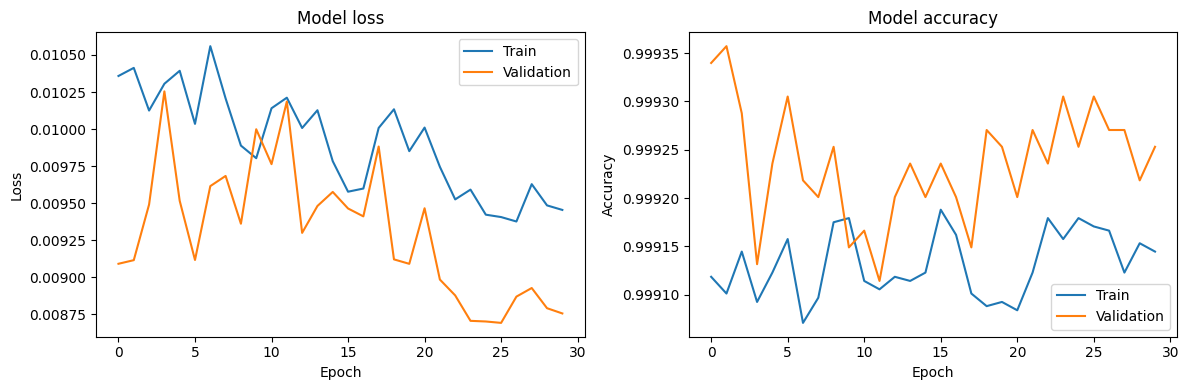

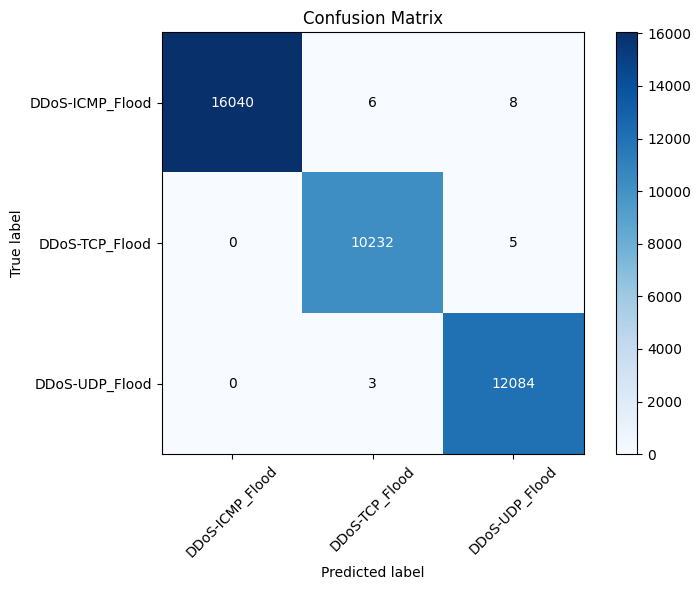

In [ ]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(model_history)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes_mlp)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve (Not possible for Multiclass Classification, it is designed for Binary Class only)
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_mlp)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

## Privacy

In [ ]:
# Define your MLP model
mlp_model_privacy = tf.keras.Sequential([
   Dense(288, activation="relu", input_shape=(len(categorical_columns),)),
  Dropout(0.2),
  Dense(288, activation="relu"),
  Dense(64, activation="relu"),
  Dense(288, activation="relu"),
  Dense(64, activation="relu"),
  Dense(256, activation="relu"),
  Dense(128, activation="relu"),
 Dense(34, activation="softmax"),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Define differential privacy parameters
batch_size = 16
l2_norm_clip = 1.0
noise_multiplier = 1.3
num_microbatches = 1

# Create a DP optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=0.003
)

# y_train2 = tf.keras.utils.to_categorical(y_train, num_classes=2)
# y_valid2 = tf.keras.utils.to_categorical(y_valid, num_classes=2)

# Compile the model with the DP optimizer and loss function
mlp_model_privacy.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with differential privacy

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Reshape
    # y_train_fold2 = tf.keras.utils.to_categorical(y_train_fold, num_classes=2)
    # y_val_fold2 = tf.keras.utils.to_categorical(y_val_fold, num_classes=2)

    # Train the model with DP for this fold
    model_history_privacy = mlp_model_privacy.fit(X_train_fold, y_train_fold,
              epochs=30,
              validation_data=(X_val_fold, y_val_fold),
              batch_size=batch_size // num_microbatches)

    # Evaluate on the validation set
    val_loss, val_accuracy = mlp_model_privacy.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit model on full data
model_history_privacy = mlp_model_privacy.fit(X_train_scaled[categorical_columns], y_train,
              epochs=30,
              validation_split=0.2)

Epoch 1/30
14992/14992 [==============================] - 70s 4ms/step - loss: 0.9997 - accuracy: 0.5398 - val_loss: 1.1672 - val_accuracy: 0.3233
Epoch 2/30
14992/14992 [==============================] - 68s 5ms/step - loss: 0.9944 - accuracy: 0.5370 - val_loss: 0.5019 - val_accuracy: 0.9326
Epoch 3/30
14992/14992 [==============================] - 69s 5ms/step - loss: 0.9237 - accuracy: 0.5518 - val_loss: 1.1222 - val_accuracy: 0.3162
Epoch 4/30
14992/14992 [==============================] - 69s 5ms/step - loss: 1.1900 - accuracy: 0.3268 - val_loss: 1.1969 - val_accuracy: 0.3162
Epoch 5/30
14992/14992 [==============================] - 70s 5ms/step - loss: 1.1736 - accuracy: 0.3615 - val_loss: 1.2466 - val_accuracy: 0.4204
Epoch 6/30
14992/14992 [==============================] - 67s 4ms/step - loss: 1.1679 - accuracy: 0.4022 - val_loss: 1.1492 - val_accuracy: 0.3162
Epoch 7/30
14992/14992 [==============================] - 70s 5ms/step - loss: 1.2583 - accuracy: 0.3235 - val_loss: 1

In [ ]:
# Predict on the test data
y_test_pred_mlp_privacy = mlp_model_privacy.predict(X_test_scaled[categorical_columns])

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

1200/1200 [==============================] - 2s 1ms/step


In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 4.112178901831309
Average cross-validation accuracy: 0.42045068740844727
MLP Model:
Accuracy =  0.4183125749127104
Precision = 0.13943752497090348
Recall = 0.3333333333333333
F1 Score =  0.19662453458749754


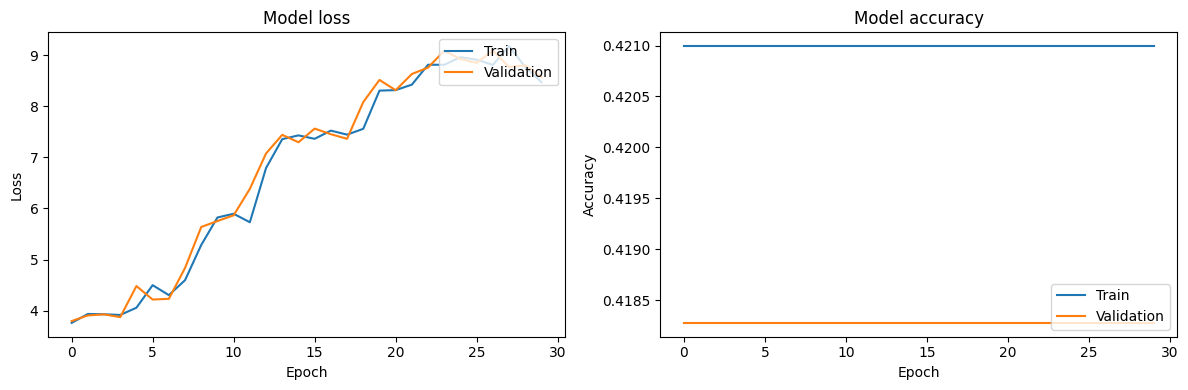

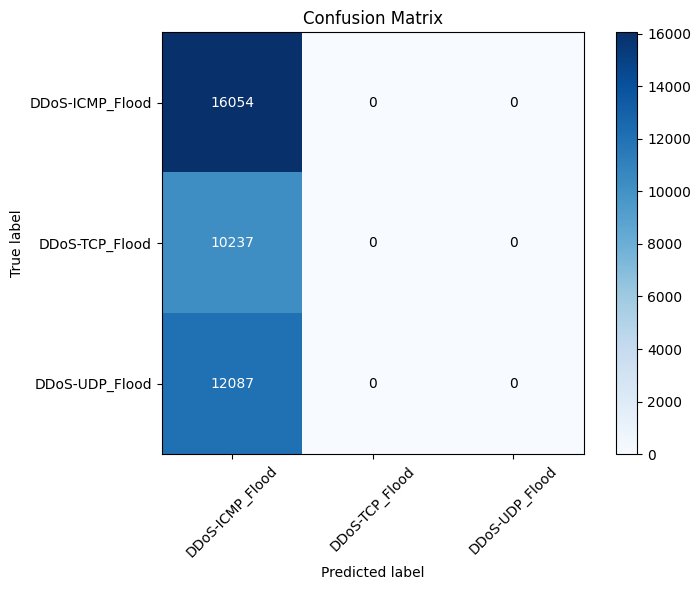

In [ ]:
# Plot loss curves
plot_loss(model_history_privacy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_binary_mlp_privacy)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Privacy Model Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Privacy Model Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

In [ ]:
# Extract trainable variables from the model
trainable_variables = mlp_model_privacy.trainable_variables

#correct function
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_scaled),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=30,
    delta=1e-5
)

# Compute privacy budget
#privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_statement(
   # number_of_examples=len(X_train_scaled),
   # batch_size=batch_size,
   # noise_multiplier=noise_multiplier,
   # num_epochs=3,
   # delta=1e-5
#)

In [ ]:
print(privacy_report)

DP-SGD performed over 287834 examples with 16 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      1.381

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



## Combine Results

In [ ]:
# Create DataFrame
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Regular': [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp],
    'Privacy': [accuracy_mlp_privacy, precision_mlp_privacy, recall_mlp_privacy, f1_mlp_privacy]
}

df = pd.DataFrame(data)

# Print DataFrame
display(df)

,Metric,Regular,Privacy
0,Accuracy,0.999427,0.418313
1,Precision,0.999349,0.139438
2,Recall,0.999464,0.333333
3,F1 Score,0.999406,0.196625


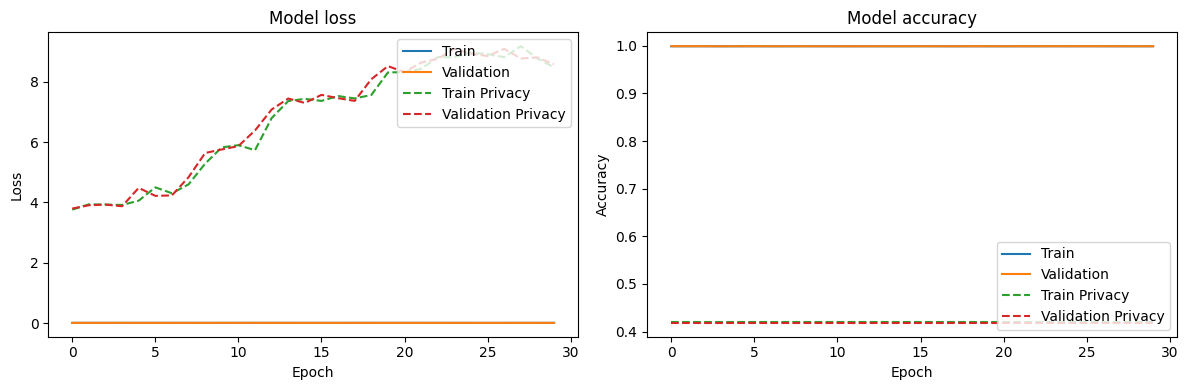

In [ ]:
plot_loss(model_history, model_history_privacy)